In [1]:
import pandas as pd
import kinproc as kp
from kinproc.jtsFunctions import *
from Kinematics_Dataframe import Kinematics_Dataframe
from utils import *
from Meta_Algorithm import *
import pickle
import numpy as np
import sklearn

In [2]:
def load_sklearn_model_from_pickle(model_name):
    import pickle

    with open(model_name, "rb") as file:
        model = pickle.load(file)
    return model

In [3]:
svm_model = load_sklearn_model_from_pickle("svm_model.sav")
stacked_model = load_sklearn_model_from_pickle("stacked_model.sav")
knn_model = load_sklearn_model_from_pickle("knn_model.sav")

# Creating dataframes
Loading the dataframes for the totality of the data as well as the specific test set that we care about.

Because the full df has more informationm, we we are going to grab specific image sequences from the test data and append the same sequences from the total dataframe.

In [4]:
dataframe_name = "./all_kinematics_dataframe.pkl"

# load dataframe

df = pd.read_pickle(dataframe_name)
test_data_df = pd.read_pickle("../joa_paper_test_set/RAW_DATA_REFINED.kin")

In [5]:
actiyas_df = Symmetry_Trap_Solver(test_data_df, "Actiyas")
GMK_df = Symmetry_Trap_Solver(test_data_df, "GMK")
Lima_df = Symmetry_Trap_Solver(test_data_df, "Lima")
Toshi_df = Symmetry_Trap_Solver(test_data_df, "Toshi")

In [6]:
pat, ses, mvt = actiyas_df.unique_pat_sess_mvt[0]
dict_key = pat + "_" + ses + "_" + mvt
# grab the data for the first patient, session, and movement

actiyas_all = df[
    (df["Patient"] == pat) & (df["Session"] == ses) & (df["Movement"] == mvt)
].reset_index(drop=True)

# add side information to testing dataframe
side_dict = {}

for subdf in actiyas_df.sub_dataframes:
    pat, _, sess, mvt, mvt_num = subdf.split("_")
    sess = "Session_" + sess
    mvt = mvt + "_" + mvt_num
    # print(pat,sess,mvt)
    side = df[
        (df["Patient"] == pat) & (df["Session"] == sess) & (df["Movement"] == mvt)
    ]["Side"].values[0]
    # print(side)

for study_df in [actiyas_df, GMK_df, Lima_df, Toshi_df]:
    for unique_psm in study_df.unique_pat_sess_mvt:
        pat, ses, mvt = unique_psm
        dict_key = pat + "_" + ses + "_" + mvt
        side = df[
            (df["Patient"] == pat) & (df["Session"] == ses) & (df["Movement"] == mvt)
        ]["Side"].values[0]
        # print(side)
        side_dict[dict_key] = side
        # calculate the symmetric pose for each study

In [7]:
pat_sess_mvt = actiyas_df.unique_pat_sess_mvt[0]
print(pat_sess_mvt)
pat_sess_mvt_key = pat_sess_mvt[0] + "_" + pat_sess_mvt[1] + "_" + pat_sess_mvt[2]
actiyas_df.sub_dataframes[pat_sess_mvt_key].calculate_symmetric_pose(
    side_dict, plot=False
)

def mvt_key_creator(dataframe, idx):
    pat_sess_mvt = dataframe.unique_pat_sess_mvt[idx]
    pat_sess_mvt_key = (
        pat_sess_mvt[0] + "_" + pat_sess_mvt[1] + "_" + pat_sess_mvt[2]
    )
    return pat_sess_mvt_key

['T01L', 'Session_1', 'Kneel_1']


# Applying Machine Learning Models to the dataset

In [8]:
actiyas_df.sub_dataframes[pat_sess_mvt_key].correct_kinematics_with_machine_learning(
    svm_model
)
actiyas_df.sub_dataframes[pat_sess_mvt_key].create_spline()

[[ 3  4]
 [ 2 14]]


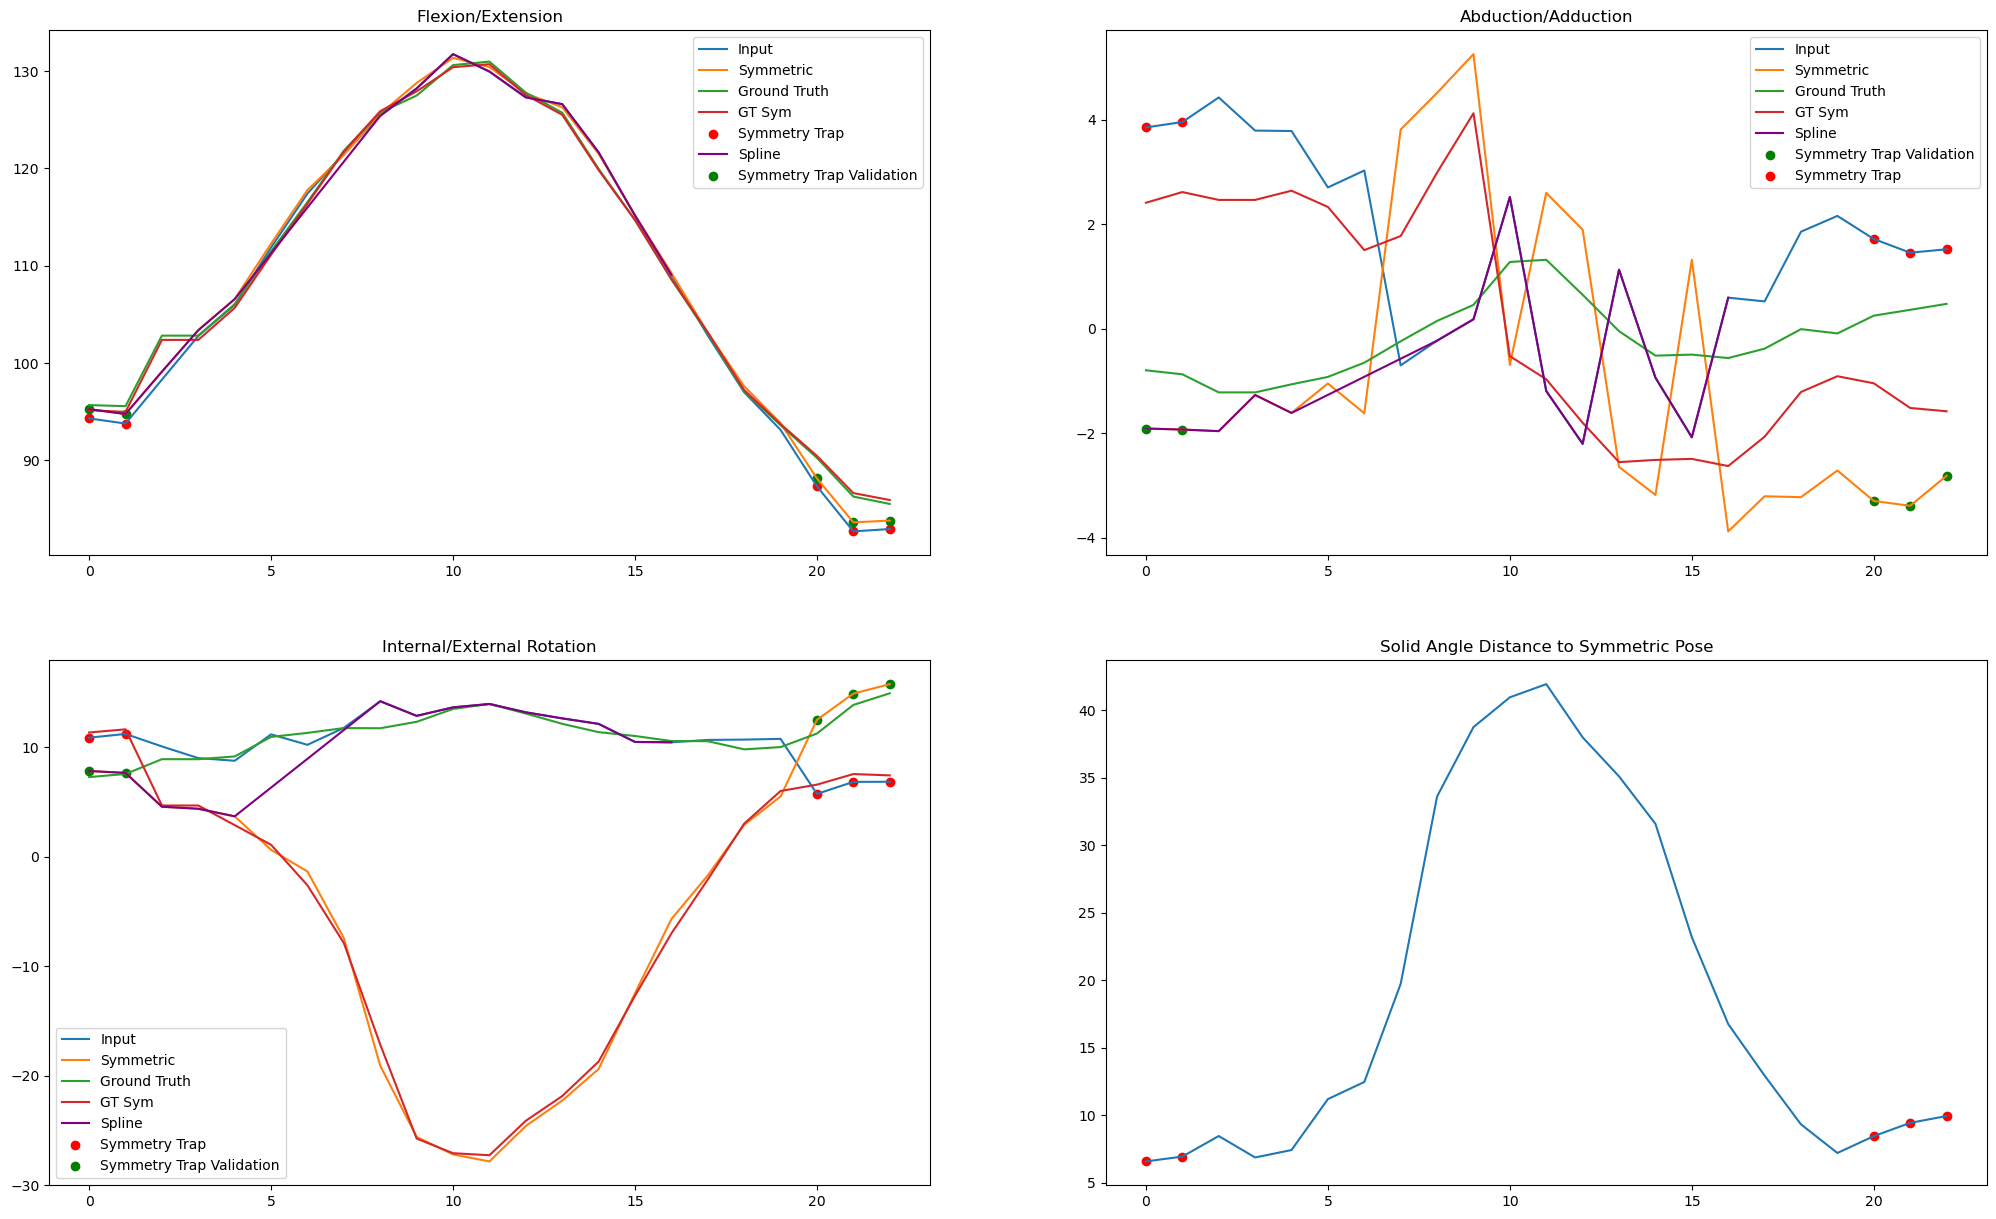

In [9]:
Xtest = np.load("X.npy")
ttest = np.load("t.npy")


actiyas_df.sub_dataframes[pat_sess_mvt_key].correct_kinematics_with_machine_learning(
    svm_model
)
actiyas_df.sub_dataframes[pat_sess_mvt_key].create_spline()
actiyas_df.sub_dataframes[pat_sess_mvt_key].apply_spline()
actiyas_df.sub_dataframes[pat_sess_mvt_key].confusion_matrix()
actiyas_df.sub_dataframes[pat_sess_mvt_key].plotting_all_kinematics()

In [10]:
def ml_workflow(model):
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0
    sym_dist_correct = []
    sym_dist_incorrect = []
    
    for study_df in [actiyas_df, GMK_df, Lima_df, Toshi_df]:
        for psm_key in study_df.sub_dataframes.keys():
            print(psm_key)
            study_df.sub_dataframes[psm_key].calculate_symmetric_pose(side_dict)
            study_df.sub_dataframes[psm_key].correct_kinematics_with_machine_learning(
                model
            )
            study_df.sub_dataframes[psm_key].create_spline()
            study_df.sub_dataframes[psm_key].apply_spline()
            tp, tn, fp, fn = study_df.sub_dataframes[psm_key].confusion_matrix()
            total_tp += tp
            total_tn += tn
            total_fp += fp
            total_fn += fn
            
            sdc, sdi = study_df.sub_dataframes[psm_key].determine_symmetry_distance_for_each_frame()
            sym_dist_correct.append(sdc)
            sym_dist_incorrect.append(sdi)
    return total_tp, total_tn, total_fp, total_fn, sym_dist_correct, sym_dist_incorrect
    

In [11]:
tp,tn,fp,fn, sym_dist_corr, sym_dist_incorr = ml_workflow(stacked_model)

T01L_Session_1_Kneel_1
[[ 5  6]
 [ 0 12]]
Mean Symmetric Distance for Correctly Classified Frames:  22.72725120821086
Mean Symmetric Distance for Incorrectly Classified Frames:  8.412486206361946
T01R_Session_1_Kneel_1
[[ 0  0]
 [ 0 23]]
Mean Symmetric Distance for Correctly Classified Frames:  25.227380435674164
T01R_Session_1_Stair_1
[[ 1  1]
 [ 1 12]]
Mean Symmetric Distance for Correctly Classified Frames:  11.498805712423575
Mean Symmetric Distance for Incorrectly Classified Frames:  12.033971246478206
T02L_Session_1_Stair_1
[[ 0  1]
 [ 0 13]]
Mean Symmetric Distance for Correctly Classified Frames:  13.404205482390866
Mean Symmetric Distance for Incorrectly Classified Frames:  6.840516489694532
T02R_Session_1_Stair_1
[[ 0  0]
 [ 0 14]]
Mean Symmetric Distance for Correctly Classified Frames:  15.8576775982612
T03L_Session_1_Stair_1
[[ 0  0]
 [ 0 15]]
Mean Symmetric Distance for Correctly Classified Frames:  18.45700450643401
T03R_Session_1_Stair_1
[[ 0  0]
 [ 0 18]]
Mean Symmetri

In [12]:
def plot_confusion_matrix(tp,tn,fp,fn):
    print(np.array([[tp,fp],[fn,tn]]))

In [13]:
plot_confusion_matrix(tp,tn,fp,fn)

[[ 34  26]
 [  9 323]]


In [14]:
def classification_metrics(tp,tn,fp,fn, print_vals = True):
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    if print_vals:
        print("Accuracy: ", np.round(accuracy,3))
        print("Precision: ", np.round(precision,3))
        print("Recall: ", np.round(recall,3))
        print("F1: ", np.round(f1,3))
        print("Sensitivity: ", np.round(sensitivity,3))
        print("Specificity: ", np.round(specificity,3))
    return accuracy, precision, recall, f1, sensitivity, specificity

In [15]:
acc, prec, rec, f1, sens, spec = classification_metrics(tp,tn,fp,fn)

Accuracy:  0.911
Precision:  0.567
Recall:  0.791
F1:  0.66
Sensitivity:  0.791
Specificity:  0.926


In [16]:
# get average of all values in sym dist corr 
# list of numpy arrays of different lengths
# average them all together

corr_sym_dist = np.array([item for sublist in sym_dist_corr for item in sublist])
print(corr_sym_dist.shape)
incorr_sym_dist = np.array([item for sublist in sym_dist_incorr for item in sublist])
print(incorr_sym_dist.shape)
print("Correct Frames symmetry distance: ", np.mean(corr_sym_dist))
print("Incorrect Frames symmetry distance: ",np.mean(incorr_sym_dist))

(357, 1)
(35, 1)
Correct Frames symmetry distance:  16.686983893998395
Incorrect Frames symmetry distance:  6.703002008505102


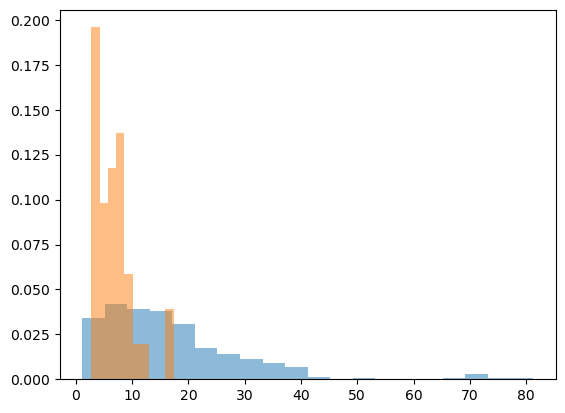

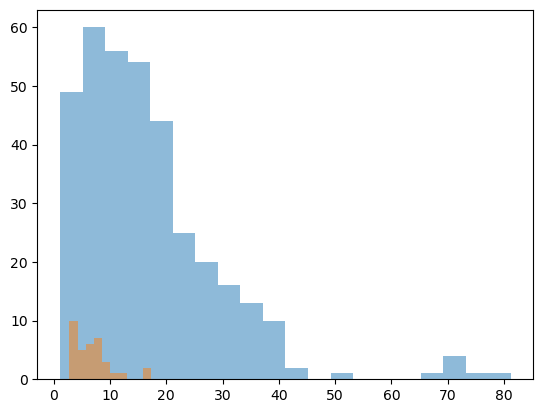

In [17]:
# Create histogram of symmetry distances
# normalize histograms
# plot on same plot

import matplotlib.pyplot as plt
# plot with normalized values
plt.hist(corr_sym_dist, bins=20, density=True, alpha=0.5)
plt.hist(incorr_sym_dist, bins=10, density=True, alpha=0.5)
plt.show()

plt.hist(corr_sym_dist, bins=20, alpha=0.5)
plt.hist(incorr_sym_dist, bins=10, alpha=0.5)
plt.show()

/home/ajensen123@ad.ufl.edu/repo/symmetry-trap-analysis/2023-all-data-analysis/Meta_Algorithm.py:502: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels([str(int(x)) + u"\u00b0" for x in axs.get_yticks()])


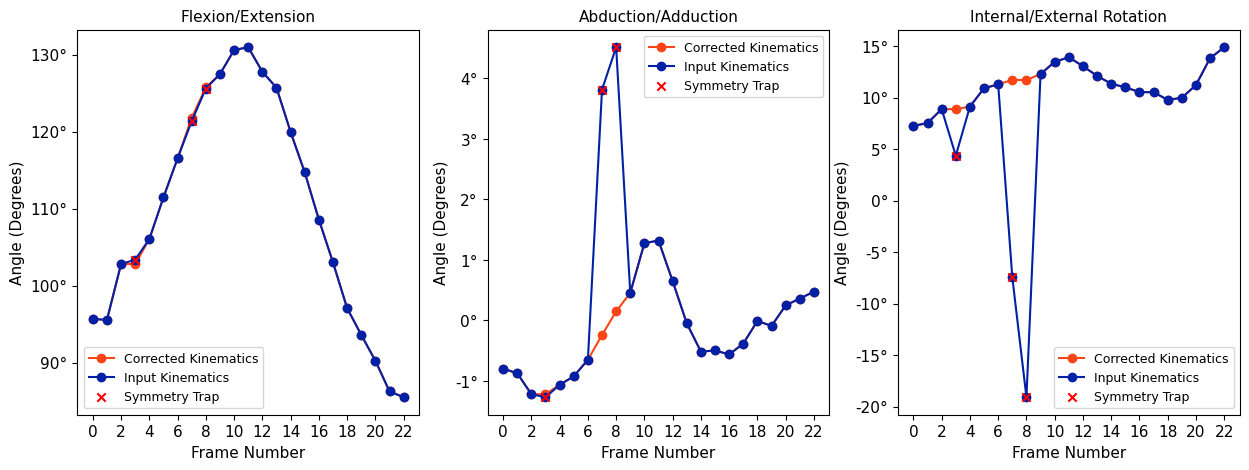

In [18]:
actiyas_df.sub_dataframes[pat_sess_mvt_key].create_kinematics_with_symmetry_traps(plot=True)

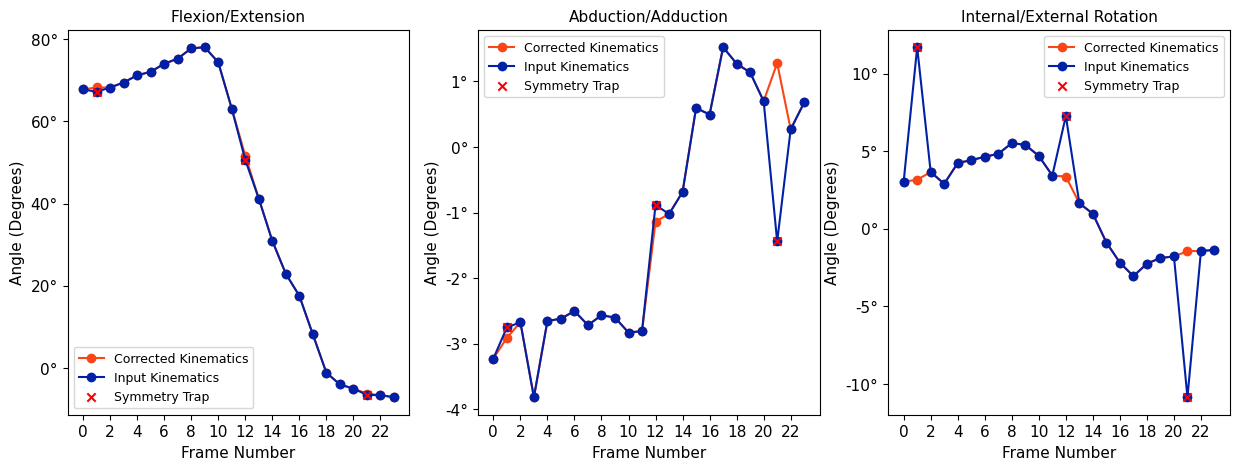

In [23]:
Lima_df.sub_dataframes[mvt_key_creator(Lima_df, 12)].create_kinematics_with_symmetry_traps(plot=True)
#GMK_df.sub_dataframes[mvt_key_creator(GMK_df, 0)].create_kinematics_with_symmetry_traps(plot=True)
